Pedestrian Detection using YOLO




Importing required library

In [12]:
import cv2
import numpy as np 
import argparse
import time

Mounting the drive

In [13]:
# Mount data from drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load Yolo model

In [19]:
def loadYoloModel():
	net = cv2.dnn.readNet("/content/drive/My Drive/yolo/yolov3.weights", "/content/drive/My Drive/yolo/yolov3.cfg")
	classes = []
	with open("config.names", "r") as f:
		classes = [line.strip() for line in f.readlines()]
	layers_names = net.getLayerNames()
	output_layers = [layers_names[i[0]-1] for i in net.getUnconnectedOutLayers()]
	colors = np.random.uniform(0, 255, size=(len(classes), 3))
	return net, classes, colors, output_layers

Load Image

In [20]:
def loadImage(img_path):
	# image loading
	img = cv2.imread(img_path)
	img = cv2.resize(img, None, fx=0.4, fy=0.4)
	height, width, channels = img.shape
	return img, height, width, channels

Detect Objects

In [21]:
def detectObjects(img, net, outputLayers):			
	blob = cv2.dnn.blobFromImage(img, scalefactor=0.00392, size=(320, 320), mean=(0, 0, 0), swapRB=True, crop=False)
	net.setInput(blob)
	outputs = net.forward(outputLayers)
	return blob, outputs

Get box dimensions

In [22]:
def getBoxDimensions(outputs, height, width):
	boxes = []
	confs = []
	class_ids = []
	for output in outputs:
		for detect in output:
			scores = detect[5:]
			class_id = np.argmax(scores)
			conf = scores[class_id]
			if conf > 0.3:
				center_x = int(detect[0] * width)
				center_y = int(detect[1] * height)
				w = int(detect[2] * width)
				h = int(detect[3] * height)
				x = int(center_x - w/2)
				y = int(center_y - h / 2)
				boxes.append([x, y, w, h])
				confs.append(float(conf))
				class_ids.append(class_id)
	return boxes, confs, class_ids

Add bounding box and label to the object

In [23]:
def drawLabels(boxes, confs, colors, class_ids, classes, img): 
  COLORS = np.random.uniform(0, 255, size=(80, 3))
  indexes = cv2.dnn.NMSBoxes(boxes, confs, 0.5, 0.4)
  font = cv2.FONT_HERSHEY_PLAIN
  for i in range(len(boxes)):
    if i in indexes:
      x, y, w, h = boxes[i]
      label = str(classes[class_ids[i]])
      color = COLORS[0]
      if label == "person":
        cv2.rectangle(img, (x,y), (x+w, y+h), color, 2)
        cv2.putText(img, label, (x, y - 5), font, 1, color, 1)
  outputImage = cv2.imwrite("person.jpg", img)
  return img


Inference code

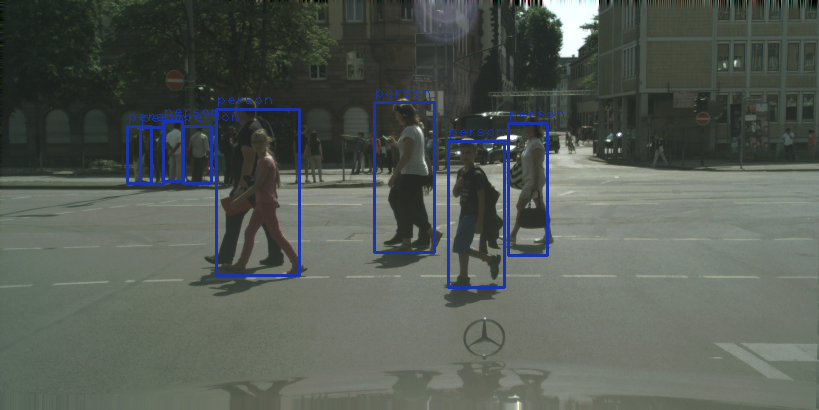

In [27]:
def personDetect(img_path): 
  model, classes, colors, output_layers = loadYoloModel()
  image, height, width, channels = loadImage(img_path)
  blob, outputs = detectObjects(image, model, output_layers)
  boxes, confs, class_ids = getBoxDimensions(outputs, height, width)
  outputImage = drawLabels(boxes, confs, colors, class_ids, classes, image)
  return outputImage
outputImage = personDetect("frankfurt1.png")
from google.colab.patches import cv2_imshow
cv2_imshow(outputImage)